In [1]:
# Add graphviz to path
import os

os.environ["PATH"] = os.environ["PATH"] + ":/opt/homebrew/bin"

# Imports
from datetime import date
from itertools import product
from pprint import pprint

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import logit

from vaxflux.covariates import (
    CovariateCategories,
    GaussianRandomWalkCovariate,
    PooledCovariate,
)
from vaxflux.curves import LogisticIncidenceCurve
from vaxflux.data import sample_dataset
from vaxflux.dates import SeasonRange, daily_date_ranges
from vaxflux.uptake import SeasonalUptakeModel

In [2]:
logistic_curve = LogisticIncidenceCurve()
logistic_curve

In [3]:
logistic_curve.parameters

('m', 'r', 's')

In [4]:
season_ranges = [
    SeasonRange(
        season="2022/23", start_date=date(2022, 9, 5), end_date=date(2023, 3, 26)
    ),
    SeasonRange(
        season="2023/24", start_date=date(2023, 9, 4), end_date=date(2024, 3, 31)
    ),
    SeasonRange(
        season="2024/25", start_date=date(2024, 9, 2), end_date=date(2025, 3, 30)
    ),
]
date_ranges = daily_date_ranges(season_ranges, range_days=6)

In [5]:
sex_cov = CovariateCategories(covariate="sex", categories=("female", "male"))
age_cov = CovariateCategories(
    covariate="age", categories=("adult", "senior", "elderly")
)

In [6]:
params = []

params_grid = {
    "2022/23": {
        "m": 0.35,
        "r": -3.2,
        "s": 40.0,
        "male": {
            "m": -0.02,
        },
        "senior": {
            "m": 0.2,
        },
        "elderly": {
            "m": 0.4,
        },
    },
    "2023/24": {
        "m": 0.31,
        "r": -3.1,
        "s": 42.5,
        "male": {
            "m": -0.015,
        },
        "senior": {
            "m": 0.22,
        },
        "elderly": {
            "m": 0.42,
        },
    },
    "2024/25": {
        "m": 0.32,
        "r": -3.3,
        "s": 41.0,
        "male": {
            "m": -0.025,
        },
        "senior": {
            "m": 0.16,
        },
        "elderly": {
            "m": 0.39,
        },
    },
}

for curve_param in logistic_curve.parameters:
    for season_range in season_ranges:
        for sex_category in sex_cov.categories:
            for age_category in age_cov.categories:
                season_params = params_grid[season_range.season]
                param_value = (
                    season_params[curve_param]
                    + season_params.get(sex_category, {}).get(curve_param, 0)
                    + season_params.get(age_category, {}).get(curve_param, 0)
                )
                if curve_param == "m":
                    param_value = logit(param_value)
                params.append(
                    (
                        curve_param,
                        season_range.season,
                        sex_category,
                        age_category,
                        param_value,
                    )
                )

pprint(params)

[('m', '2022/23', 'female', 'adult', -0.6190392084062235),
 ('m', '2022/23', 'female', 'senior', 0.20067069546215133),
 ('m', '2022/23', 'female', 'elderly', 1.0986122886681098),
 ('m', '2022/23', 'male', 'adult', -0.7081850579244859),
 ('m', '2022/23', 'male', 'senior', 0.12014431184206335),
 ('m', '2022/23', 'male', 'elderly', 0.9946225751440619),
 ('m', '2023/24', 'female', 'adult', -0.8001193001121132),
 ('m', '2023/24', 'female', 'senior', 0.12014431184206335),
 ('m', '2023/24', 'female', 'elderly', 0.9946225751440619),
 ('m', '2023/24', 'male', 'adult', -0.871222446472449),
 ('m', '2023/24', 'male', 'senior', 0.060018009726253),
 ('m', '2023/24', 'male', 'elderly', 0.919793362425357),
 ('m', '2024/25', 'female', 'adult', -0.7537718023763801),
 ('m', '2024/25', 'female', 'senior', -0.0800427076735365),
 ('m', '2024/25', 'female', 'elderly', 0.8953840470548413),
 ('m', '2024/25', 'male', 'adult', -0.871222446472449),
 ('m', '2024/25', 'male', 'senior', -0.1804883757122938),
 ('m', 

In [7]:
observations = sample_dataset(
    logistic_curve, season_ranges, date_ranges, [sex_cov, age_cov], params, 0.0005
)
observations

,season,season_start_date,season_end_date,start_date,end_date,report_date,sex,age,type,value
0,2022/23,2022-09-05,2023-03-26,2022-09-05,2022-09-11,2022-09-11,female,adult,incidence,1.516720e-02
1,2022/23,2022-09-05,2023-03-26,2022-09-05,2022-09-11,2022-09-11,female,senior,incidence,2.225160e-02
2,2022/23,2022-09-05,2023-03-26,2022-09-05,2022-09-11,2022-09-11,female,elderly,incidence,3.227621e-02
3,2022/23,2022-09-05,2023-03-26,2022-09-05,2022-09-11,2022-09-11,male,adult,incidence,1.278428e-02
4,2022/23,2022-09-05,2023-03-26,2022-09-05,2022-09-11,2022-09-11,male,senior,incidence,2.167275e-02
...,...,...,...,...,...,...,...,...,...,...
529,2024/25,2024-09-02,2025-03-30,2025-03-24,2025-03-30,2025-03-30,female,senior,incidence,1.123163e-03
530,2024/25,2024-09-02,2025-03-30,2025-03-24,2025-03-30,2025-03-30,female,elderly,incidence,1.654892e-03
531,2024/25,2024-09-02,2025-03-30,2025-03-24,2025-03-30,2025-03-30,male,adult,incidence,7.937817e-39
532,2024/25,2024-09-02,2025-03-30,2025-03-24,2025-03-30,2025-03-30,male,senior,incidence,7.181577e-07


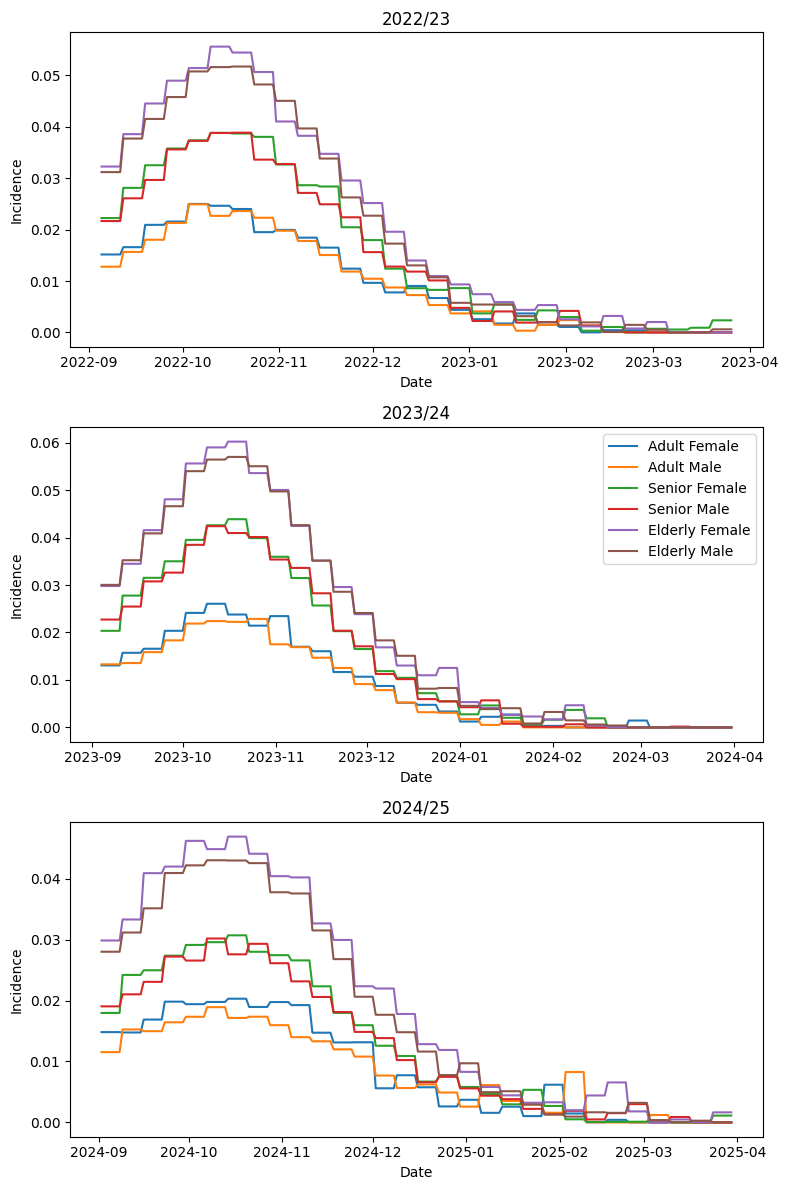

In [8]:
fig, axes = plt.subplots(
    nrows=len(season_ranges),
    ncols=1,
    figsize=(8, 12),
)

for i, season_range in enumerate(season_ranges):
    ax = axes[i]
    ax.set_title(season_range.season)
    ax.set_xlabel("Date")
    ax.set_ylabel("Incidence")
    for age_category in age_cov.categories:
        for sex_category in sex_cov.categories:
            observations_subset = observations[
                (observations["season"] == season_range.season)
                & (observations["age"] == age_category)
                & (observations["sex"] == sex_category)
            ]
            x = [
                el
                for pair in zip(
                    observations_subset["start_date"].tolist(),
                    observations_subset["end_date"].tolist(),
                )
                for el in pair
            ]
            y = [
                el
                for pair in zip(
                    observations_subset["value"].tolist(),
                    observations_subset["value"].tolist(),
                )
                for el in pair
            ]
            ax.plot(x, y, label=f"{age_category.title()} {sex_category.title()}")
    if i == (len(season_ranges) // 2):
        ax.legend()

fig.tight_layout()
plt.show()

In [9]:
observations_prevalence = observations.copy()
observations_prevalence = observations_prevalence.sort_values(
    [
        "start_date",
        "end_date",
        "season",
        "season_start_date",
        "season_end_date",
        "sex",
        "age",
    ]
)
observations_prevalence["prevalence"] = (
    observations_prevalence.groupby(["season", "sex", "age"])["value"]
    .cumsum()
    .reset_index()["value"]
)
observations_prevalence

,season,season_start_date,season_end_date,start_date,end_date,report_date,sex,age,type,value,prevalence
0,2022/23,2022-09-05,2023-03-26,2022-09-05,2022-09-11,2022-09-11,female,adult,incidence,1.516720e-02,0.015167
2,2022/23,2022-09-05,2023-03-26,2022-09-05,2022-09-11,2022-09-11,female,elderly,incidence,3.227621e-02,0.022252
1,2022/23,2022-09-05,2023-03-26,2022-09-05,2022-09-11,2022-09-11,female,senior,incidence,2.225160e-02,0.032276
3,2022/23,2022-09-05,2023-03-26,2022-09-05,2022-09-11,2022-09-11,male,adult,incidence,1.278428e-02,0.012784
5,2022/23,2022-09-05,2023-03-26,2022-09-05,2022-09-11,2022-09-11,male,elderly,incidence,3.119449e-02,0.021673
...,...,...,...,...,...,...,...,...,...,...,...
530,2024/25,2024-09-02,2025-03-30,2025-03-24,2025-03-30,2025-03-30,female,elderly,incidence,1.654892e-03,0.383690
529,2024/25,2024-09-02,2025-03-30,2025-03-24,2025-03-30,2025-03-30,female,senior,incidence,1.123163e-03,0.600141
531,2024/25,2024-09-02,2025-03-30,2025-03-24,2025-03-30,2025-03-30,male,adult,incidence,7.937817e-39,0.245707
533,2024/25,2024-09-02,2025-03-30,2025-03-24,2025-03-30,2025-03-30,male,elderly,incidence,5.035507e-11,0.370048


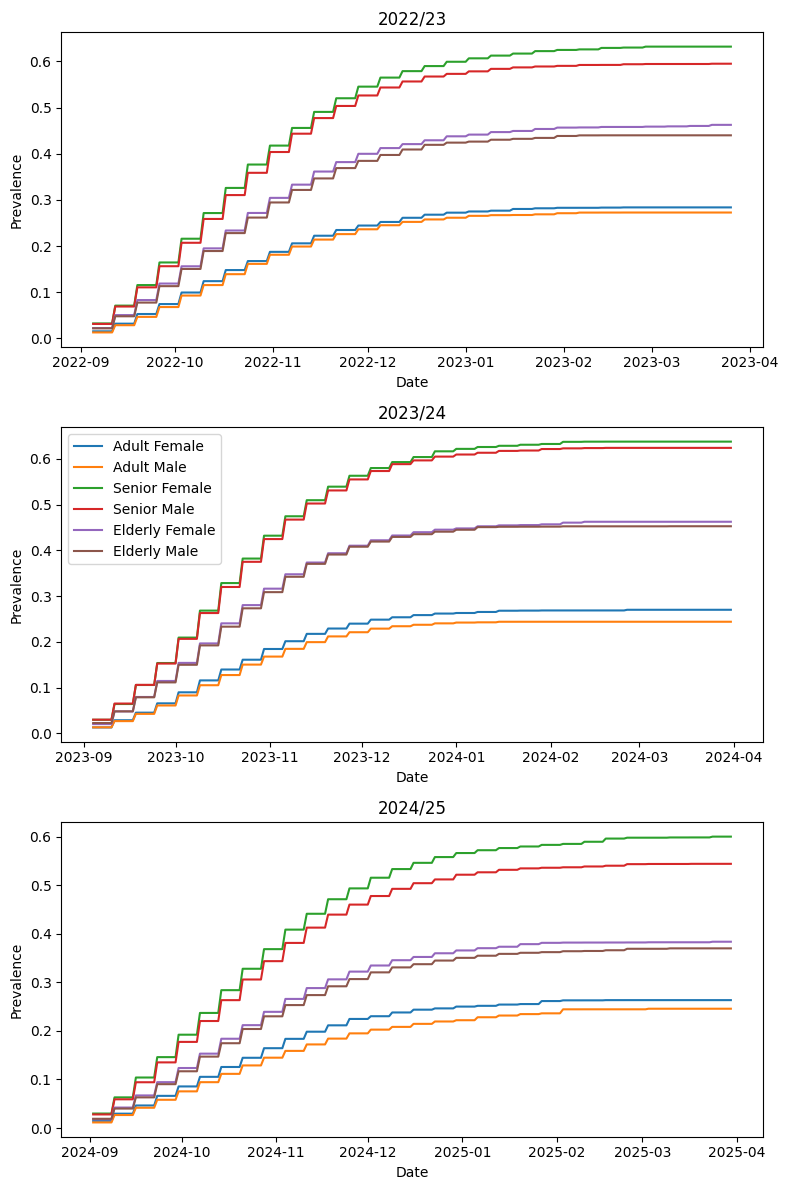

In [10]:
fig, axes = plt.subplots(
    nrows=len(season_ranges),
    ncols=1,
    figsize=(8, 12),
)

for i, season_range in enumerate(season_ranges):
    ax = axes[i]
    ax.set_title(season_range.season)
    ax.set_xlabel("Date")
    ax.set_ylabel("Prevalence")
    for age_category in age_cov.categories:
        for sex_category in sex_cov.categories:
            observations_subset = observations_prevalence[
                (observations_prevalence["season"] == season_range.season)
                & (observations_prevalence["age"] == age_category)
                & (observations_prevalence["sex"] == sex_category)
            ]
            x = [
                el
                for pair in zip(
                    observations_subset["start_date"].tolist(),
                    observations_subset["end_date"].tolist(),
                )
                for el in pair
            ]
            y = [
                el
                for pair in zip(
                    observations_subset["prevalence"].tolist(),
                    observations_subset["prevalence"].tolist(),
                )
                for el in pair
            ]
            ax.plot(x, y, label=f"{age_category.title()} {sex_category.title()}")
    if i == (len(season_ranges) // 2):
        ax.legend()

fig.tight_layout()
plt.show()

In [11]:
model = SeasonalUptakeModel(
    logistic_curve,
    [
        PooledCovariate(
            parameter="m",
            covariate=None,
            distribution="Normal",
            distribution_kwargs={"mu": -0.5, "sigma": 0.2},
        ),
        PooledCovariate(
            parameter="r",
            covariate=None,
            distribution="Normal",
            distribution_kwargs={"mu": -3.0, "sigma": 0.75},
        ),
        PooledCovariate(
            parameter="s",
            covariate=None,
            distribution="Normal",
            distribution_kwargs={"mu": 40.0, "sigma": 8.0},
        ),
        GaussianRandomWalkCovariate(
            parameter="m",
            covariate="age",
            init_mu=[0.2, 0.4],
            mu=2 * [0.0],
            sigma=2 * [0.05],
        ),
        GaussianRandomWalkCovariate(
            parameter="m",
            covariate="sex",
            init_mu=-0.05,
            mu=0.0,
            sigma=0.01,
        ),
    ],
    observations=observations,
    covariate_categories=[sex_cov, age_cov],
    season_ranges=season_ranges,
    date_ranges=date_ranges,
    epsilon=0.001,
    # Custom keyword arguments
    constrain_prevalence=False,
    observation_sigma=1e-4,
    pooled_epsilon=True,
)
model

In [12]:
model.build(debug=True)

INFO: Using 89 date ranges for the uptake model.
INFO: Using 534 observational date ranges for the uptake model.
INFO: Added season 2022/23 to the model with 203 days.
INFO: Added season 2023/24 to the model with 210 days.
INFO: Added season 2024/25 to the model with 210 days.
INFO: Added covariate MSeason to the model with shape [3].
INFO: Added covariate RSeason to the model with shape [3].
INFO: Added covariate SSeason to the model with shape [3].
INFO: Added covariate MAge to the model with shape [3 2].
INFO: Added covariate MSex to the model with shape [3].
INFO: Added summed parameter MSeason202223SexFemaleAgeAdult to the model.
INFO: Added summed parameter RSeason202223SexFemaleAgeAdult to the model.
INFO: Added summed parameter SSeason202223SexFemaleAgeAdult to the model.
INFO: Added summed parameter MSeason202324SexFemaleAgeAdult to the model.
INFO: Added summed parameter RSeason202324SexFemaleAgeAdult to the model.
INFO: Added summed parameter SSeason202324SexFemaleAgeAdult t

In [13]:
model.sample(
    tune=3000,
    draws=2000,
    chains=4,
)

Running window adaptation


There were 7756 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


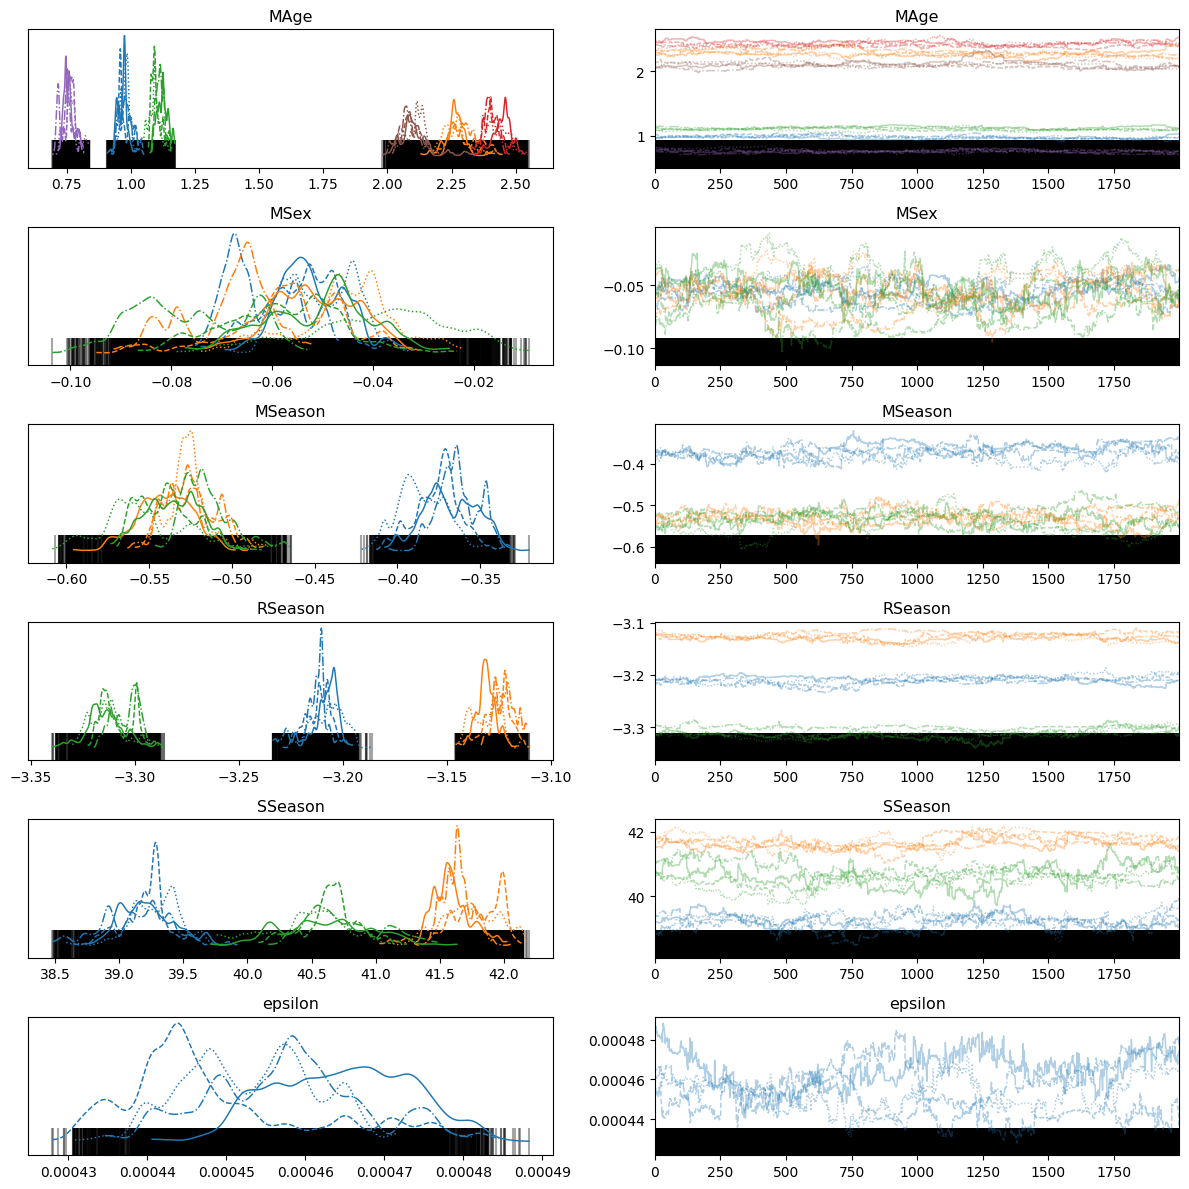

In [14]:
az.plot_trace(
    model._trace, var_names=["MAge", "MSex", "MSeason", "RSeason", "SSeason", "epsilon"]
)
plt.tight_layout()

In [15]:
incidence_posterior_df = model.dataframe()
incidence_posterior_df.head(10)

,draw,chain,season,date,sex,age,type,value
0,0,0,2022/23,2022-09-05,female,adult,incidence,0.003253
1,0,0,2022/23,2022-09-06,female,adult,incidence,0.001742
2,0,0,2022/23,2022-09-07,female,adult,incidence,0.002585
3,0,0,2022/23,2022-09-08,female,adult,incidence,0.001988
4,0,0,2022/23,2022-09-09,female,adult,incidence,0.002748
5,0,0,2022/23,2022-09-10,female,adult,incidence,0.002731
6,0,0,2022/23,2022-09-11,female,adult,incidence,0.002288
7,0,0,2022/23,2022-09-12,female,adult,incidence,0.002110
8,0,0,2022/23,2022-09-13,female,adult,incidence,0.002413
9,0,0,2022/23,2022-09-14,female,adult,incidence,0.002973


In [16]:
incidence_posterior_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29904000 entries, 0 to 1679999
Data columns (total 8 columns):
 #   Column  Dtype         
---  ------  -----         
 0   draw    int64         
 1   chain   int64         
 2   season  string        
 3   date    datetime64[ns]
 4   sex     string        
 5   age     string        
 6   type    string        
 7   value   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), string(4)
memory usage: 2.0 GB


In [17]:
summary_posterior_df = (
    incidence_posterior_df.groupby(
        ["chain", "draw", "season", pd.Grouper(key="date", freq="W"), "sex", "age"]
    )["value"]
    .sum()
    .reset_index()
)
summary_posterior_df = summary_posterior_df.rename(columns={"date": "end_date"})
summary_posterior_df["start_date"] = summary_posterior_df["end_date"] - pd.Timedelta(
    days=6
)
summary_posterior_df = (
    summary_posterior_df.groupby(["season", "start_date", "end_date", "sex", "age"])[
        "value"
    ]
    .agg(
        [
            lambda x: np.quantile(x, 0.025),
            lambda x: np.quantile(x, 0.5),
            lambda x: np.quantile(x, 0.975),
        ]
    )
    .reset_index()
)
summary_posterior_df = summary_posterior_df.rename(
    columns={
        summary_posterior_df.columns[-3]: "lower",
        summary_posterior_df.columns[-2]: "median",
        summary_posterior_df.columns[-1]: "upper",
    }
)
summary_posterior_df

,season,start_date,end_date,sex,age,lower,median,upper
0,2022/23,2022-09-05,2022-09-11,female,adult,1.707990e-02,1.788074e-02,0.018847
1,2022/23,2022-09-05,2022-09-11,female,elderly,3.711995e-02,3.805888e-02,0.038852
2,2022/23,2022-09-05,2022-09-11,female,senior,2.582430e-02,2.655043e-02,0.027353
3,2022/23,2022-09-05,2022-09-11,male,adult,1.464734e-02,1.553314e-02,0.016713
4,2022/23,2022-09-05,2022-09-11,male,elderly,3.601065e-02,3.707455e-02,0.038094
...,...,...,...,...,...,...,...,...
529,2024/25,2025-03-24,2025-03-30,female,elderly,1.449780e-03,1.655609e-03,0.002288
530,2024/25,2025-03-24,2025-03-30,female,senior,9.209712e-04,1.118405e-03,0.001795
531,2024/25,2025-03-24,2025-03-30,male,adult,9.444049e-50,1.286878e-12,0.000108
532,2024/25,2025-03-24,2025-03-30,male,elderly,1.716233e-13,3.078673e-06,0.000579


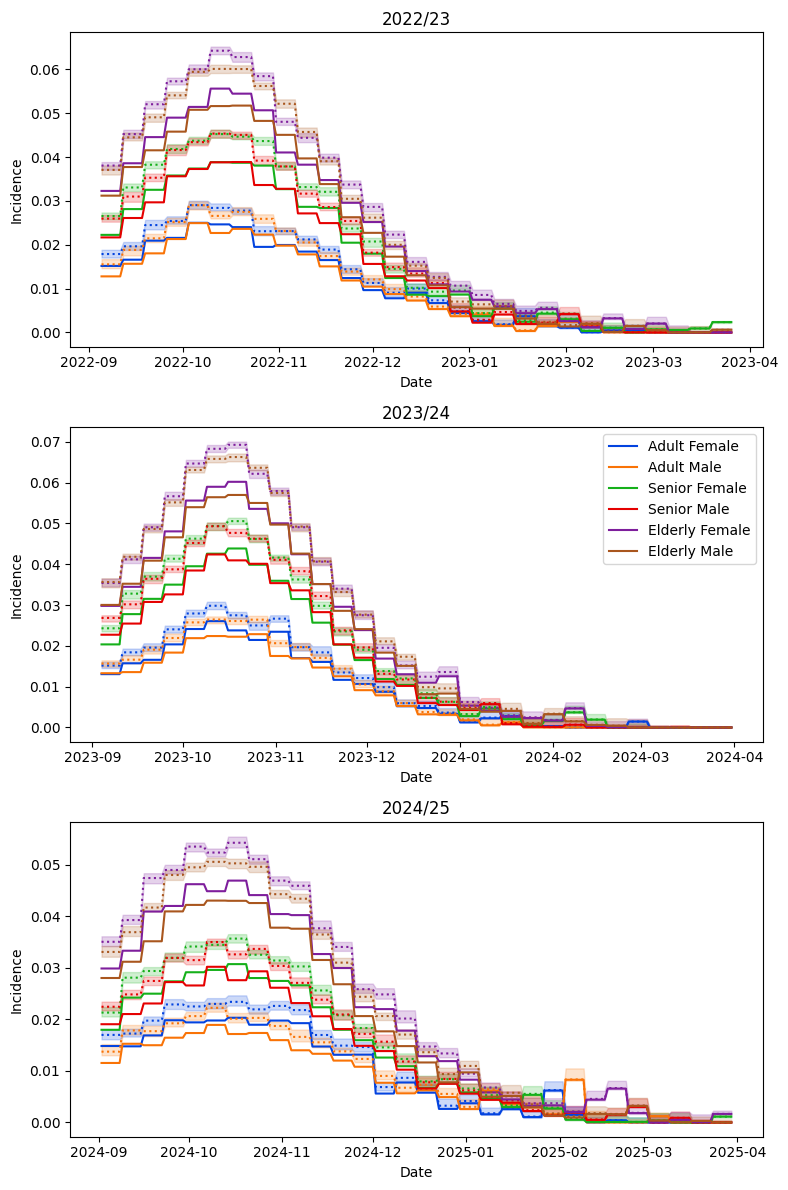

In [18]:
fig, axes = plt.subplots(
    nrows=len(season_ranges),
    ncols=1,
    figsize=(8, 12),
)

colors = (
    "xkcd:blue",
    "xkcd:orange",
    "xkcd:green",
    "xkcd:red",
    "xkcd:purple",
    "xkcd:sienna",
)
colors_map = {
    hash((age_category, sex_category)): color
    for color, (age_category, sex_category) in zip(
        colors, product(age_cov.categories, sex_cov.categories)
    )
}

for i, season_range in enumerate(season_ranges):
    ax = axes[i]
    ax.set_title(season_range.season)
    ax.set_xlabel("Date")
    ax.set_ylabel("Incidence")
    for age_category in age_cov.categories:
        for sex_category in sex_cov.categories:
            color = colors_map[hash((age_category, sex_category))]
            observations_subset = observations[
                (observations["season"] == season_range.season)
                & (observations["age"] == age_category)
                & (observations["sex"] == sex_category)
            ]
            x = [
                el
                for pair in zip(
                    observations_subset["start_date"].tolist(),
                    observations_subset["end_date"].tolist(),
                )
                for el in pair
            ]
            y = [
                el
                for pair in zip(
                    observations_subset["value"].tolist(),
                    observations_subset["value"].tolist(),
                )
                for el in pair
            ]
            ax.plot(
                x,
                y,
                label=f"{age_category.title()} {sex_category.title()}",
                color=color,
                linestyle="-",
            )

            summary_posterior_subset = summary_posterior_df[
                (summary_posterior_df["season"] == season_range.season)
                & (summary_posterior_df["age"] == age_category)
                & (summary_posterior_df["sex"] == sex_category)
            ]
            x = [
                el
                for pair in zip(
                    summary_posterior_subset["start_date"].tolist(),
                    summary_posterior_subset["end_date"].tolist(),
                )
                for el in pair
            ]
            y = [
                el
                for pair in zip(
                    summary_posterior_subset["median"].tolist(),
                    summary_posterior_subset["median"].tolist(),
                )
                for el in pair
            ]
            ax.plot(x, y, color=color, linestyle=":")

            y1 = [
                el
                for pair in zip(
                    summary_posterior_subset["lower"].tolist(),
                    summary_posterior_subset["lower"].tolist(),
                )
                for el in pair
            ]
            y2 = [
                el
                for pair in zip(
                    summary_posterior_subset["upper"].tolist(),
                    summary_posterior_subset["upper"].tolist(),
                )
                for el in pair
            ]
            ax.fill_between(x, y1, y2, color=color, alpha=0.2)
    if i == (len(season_ranges) // 2):
        ax.legend()

fig.tight_layout()
plt.show()